In [1]:
import pandas as pd
import numpy as np

# Step One: Frame the problem

#The goal in this problem is to predict the average housing price for a given housing district, which will then be fed as an input to a more complex ML model that will be used to decide whether or not to invest in a given area or not. 

#What type of ML model (batch vs online, supervised vs unsupervised, type of model, etc) do we need to perform this task? In this case, a linear regression model would work well since we need to know the labels of existing houses, and there is a general linear trend between housing features and housing prices. 

#Select a performance measure or an evaluation metric. In this case we use root mean square error, which gives higher weight 
#to larger errors. The link below is good for selecting the best performance measures 
#https://neptune.ai/blog/performance-metrics-in-machine-learning-complete-guide

# Step Two: Download/Convert and Explore the Data

In [2]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://raw.githubusercontent.com/ageron/handson-ml2/master/"
HOUSING_PATH = os.path.join("datasets", "housing")
HOUSING_URL = DOWNLOAD_ROOT + "datasets/housing/housing.tgz"

def fetch_housing_data(housing_url=HOUSING_URL, housing_path=HOUSING_PATH):
    if not os.path.isdir(housing_path):
        os.makedirs(housing_path)
    tgz_path = os.path.join(housing_path, "housing.tgz")
    urllib.request.urlretrieve(housing_url, tgz_path)
    housing_tgz = tarfile.open(tgz_path)
    housing_tgz.extractall(path=housing_path)
    housing_tgz.close()

In [3]:
fetch_housing_data()

In [4]:
import pandas as pd

def load_housing_data(housing_path=HOUSING_PATH):
    csv_path = os.path.join(housing_path, "housing.csv")
    return pd.read_csv(csv_path)

In [5]:
housing = load_housing_data()

In [6]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [7]:
#We can observe one categorical column, so we have to use an imputer/encoder to vectorize that column 

In [8]:
housing.info()   #info returns common df information and types
#total bedrooms is the only col with null values, maybe 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [9]:
def count_outliers(df, column_name):
    column = df[column_name]
    mean = column.mean()
    std = column.std()
    threshold = 2 * std
    lower_bound = mean - threshold
    upper_bound = mean + threshold
    outliers = column[(column < lower_bound) | (column > upper_bound)]
    return len(outliers)

In [10]:
column_name = 'median_house_value'  # Replace 'column_name' with the actual column name
num_outliers = count_outliers(housing, column_name)
print(f"Number of outliers in '{column_name}': {num_outliers}")
#1383 is about 6 percent of the data, making it a reasonable number of outliers for the 2SD rule being used for outlier 
#identification

Number of outliers in 'median_house_value': 1383


In [11]:
print(len(housing))

20640


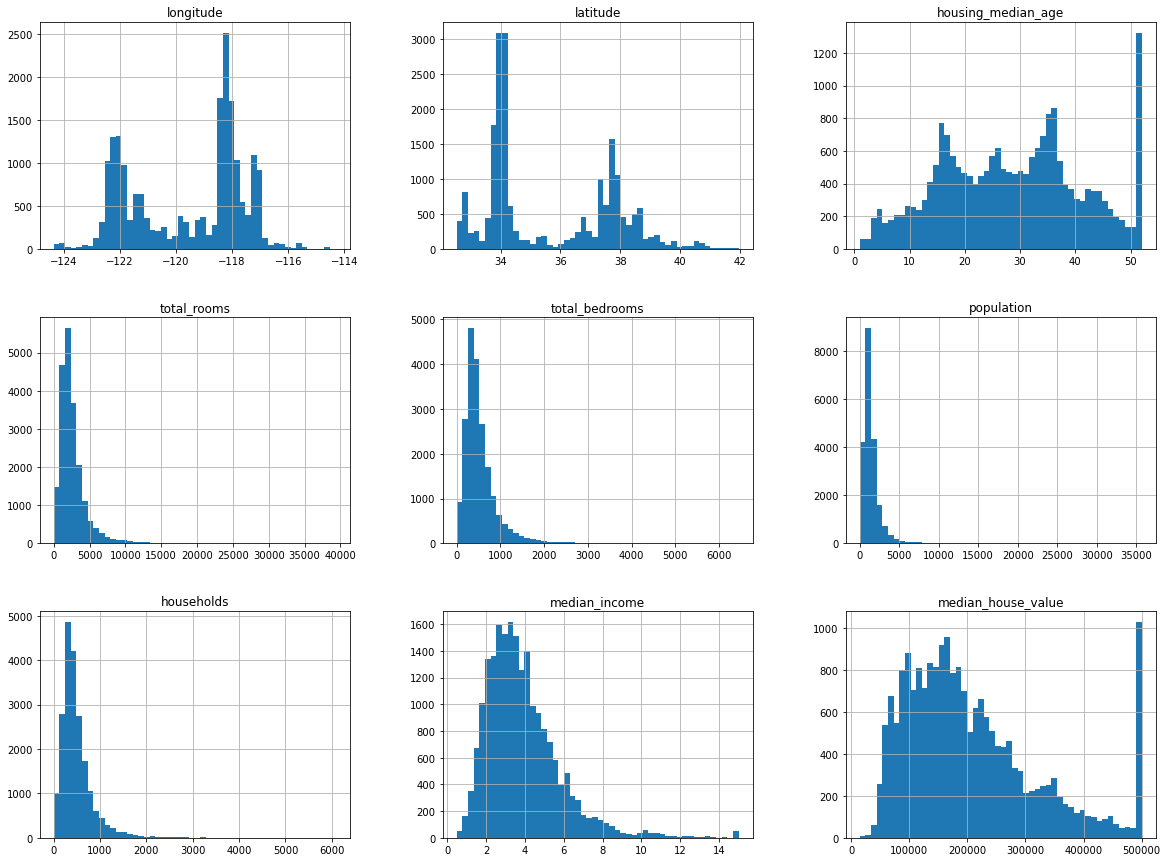

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
housing.hist(bins=50, figsize=(20,15))
plt.show()

In [13]:
#We see from the above graph a few interesting things.
#1: Median income in scaled in some way
#2: Median house value is capped at 50,000$, which could result in bad predictions. Need to fix this. Same problem with 
#housing_median_age. 


# Step Three: Create the Test Set and/or Validation Sets

random state parameter ensures that the same train and test sets are generated every execution to prevent model from seeing 
new data every time

Method One of Sampling: random sampling using train_test_split and random_state: Splits data randomly into 2 sets.

In [14]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(housing, test_size = 0.2, random_state = 42)

Method Two of Sampling: Stratified Random Sampling, which makes sure that specific proportions are met in the sets which are representative of the population.

Use random sampling when you have large datasets and/or balanced data and/or having balanced data does not matter.
Use stratified sampling when you have small datasets and/or unbalanced data and/or having balanced data does matter 
In this case, income does matter a lot and small/large incomes could have a drastic impact on predictions, so use stratificationl

In [15]:
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0., 1.5, 3.0, 4.5, 6., np.inf],
                               labels=[1, 2, 3, 4, 5])

<AxesSubplot:>

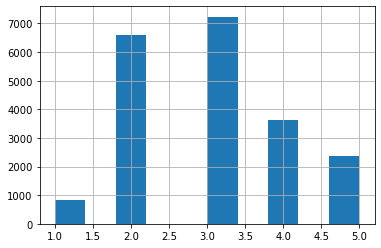

In [16]:
housing["income_cat"].hist()

In [17]:
from sklearn.model_selection import StratifiedShuffleSplit

split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(housing, housing["income_cat"]):
    strat_train_set = housing.loc[train_index]
    strat_test_set = housing.loc[test_index]

In [18]:
strat_test_set["income_cat"].value_counts() / len(strat_test_set)

3    0.350533
2    0.318798
4    0.176357
5    0.114583
1    0.039729
Name: income_cat, dtype: float64

In [19]:
housing["income_cat"].value_counts() / len(housing)

3    0.350581
2    0.318847
4    0.176308
5    0.114438
1    0.039826
Name: income_cat, dtype: float64

In [20]:
for set_ in (strat_train_set, strat_test_set):
    set_.drop("income_cat", axis=1, inplace=True)

In [21]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,income_cat
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,5
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,5
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,5
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,4
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,3


# Step Four: Data Visualization

In [22]:
housing = strat_train_set.copy()

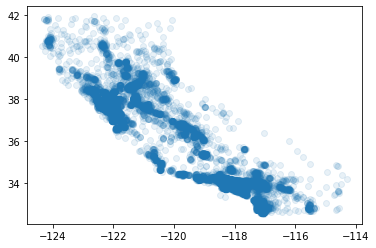

In [23]:
plt.scatter(housing['longitude'], housing['latitude'], alpha = 0.1)   #A map of california with more points in the urban areas

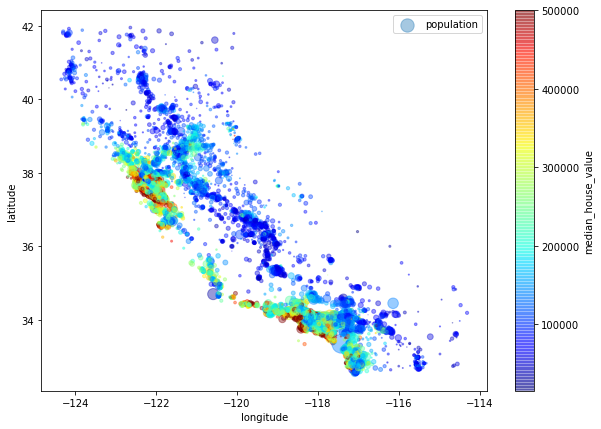

In [24]:
housing.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
             s=housing["population"]/100, label="population", figsize=(10,7),
             c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True,
             sharex=False)
plt.legend()

In [25]:
# These plots reveal that location is a very important attribute, as well as distance to coast

# Step Five: Feature Selection/Engineering

There are numerous methods for feature selection (https://towardsdatascience.com/feature-selection-techniques-in-machine-learning-with-python-f24e7da3f36e) but in this case we are using the r correlation since there are not too many cols, as well as scatter_matrix. Large datasets would require other techniques for feature selection. 

In [26]:
corr_matrix = housing.corr()

In [27]:
corr_matrix['median_house_value'].sort_values()

latitude             -0.142724
longitude            -0.047432
population           -0.026920
total_bedrooms        0.047689
households            0.064506
housing_median_age    0.114110
total_rooms           0.135097
median_income         0.687160
median_house_value    1.000000
Name: median_house_value, dtype: float64

array([[<AxesSubplot:xlabel='median_house_value', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_house_value'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_house_value'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='median_income'>,
        <AxesSubplot:xlabel='median_income', ylabel='median_income'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='median_income'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='median_income'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='median_income', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='total_rooms', ylabel='total_rooms'>,
        <AxesSubplot:xlabel='housing_median_age', ylabel='total_rooms'>],
       [<AxesSubplot:xlabel='median_house_value', ylabel='housing_median_age'>,
        <AxesSubplot:xlabel='median_incom

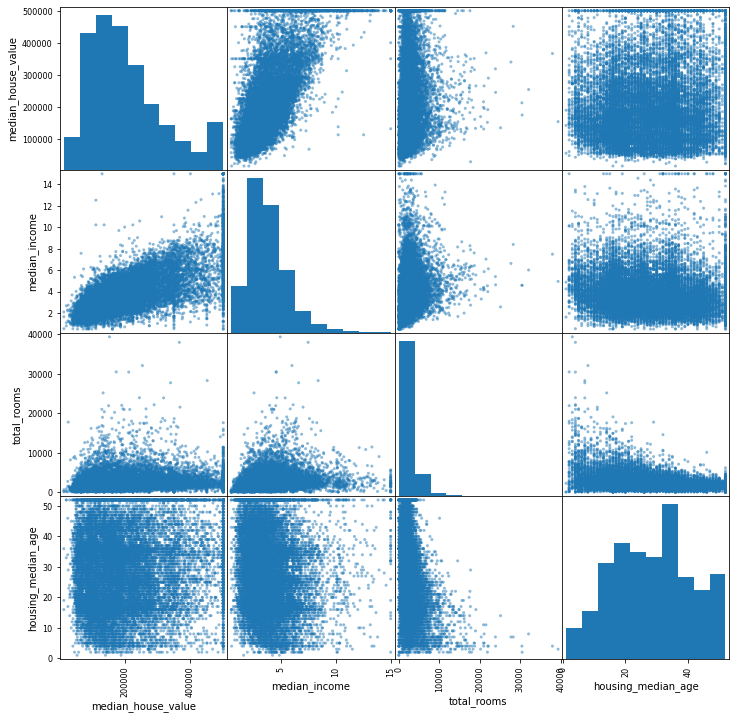

In [28]:
from pandas.plotting import scatter_matrix
attributes = ["median_house_value", "median_income", "total_rooms", "housing_median_age"]
scatter_matrix(housing[attributes], figsize = (12,12))

This corr chart shows that the most important related features by far is median_house_income and median_income. Let us look at that chart specifically

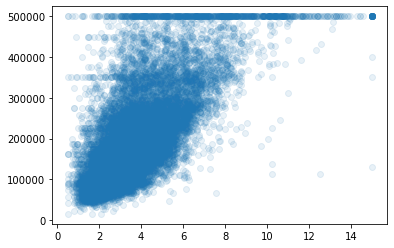

In [29]:
plt.scatter(housing['median_income'], housing['median_house_value'], alpha=0.1)

This corr chart shows numerous lines at 500,000, 450,000, 360,000, and a few below that. Not sure how that is happening, but might have to remove the houses at those points

In [30]:
housing["rooms_per_household"] = housing["total_rooms"]/housing["households"]
housing["bedrooms_per_room"] = housing["total_bedrooms"]/housing["total_rooms"]
housing["population_per_household"]=housing["population"]/housing["households"]

In [31]:
corr_matrix = housing.corr()
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value          1.000000
median_income               0.687160
rooms_per_household         0.146285
total_rooms                 0.135097
housing_median_age          0.114110
households                  0.064506
total_bedrooms              0.047689
population_per_household   -0.021985
population                 -0.026920
longitude                  -0.047432
latitude                   -0.142724
bedrooms_per_room          -0.259984
Name: median_house_value, dtype: float64

In [32]:
housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

# Step Six: Data Cleaning and Categorical Attributes 

In [33]:
from sklearn.impute import SimpleImputer

In [34]:
imputer = SimpleImputer(strategy = "median")

In [35]:
housing_num = housing.drop("ocean_proximity", axis = 1)

In [36]:
imputer.fit(housing_num)

SimpleImputer(strategy='median')

In [37]:
imputer.statistics_

array([-118.51  ,   34.26  ,   29.    , 2119.5   ,  433.    , 1164.    ,
        408.    ,    3.5409])

In [38]:
X = imputer.transform(housing_num)

In [39]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)

In [40]:
housing_cat = housing[["ocean_proximity"]]
housing_cat.head(10)

,ocean_proximity
17606,<1H OCEAN
18632,<1H OCEAN
14650,NEAR OCEAN
3230,INLAND
3555,<1H OCEAN
19480,INLAND
8879,<1H OCEAN
13685,INLAND
4937,<1H OCEAN
4861,<1H OCEAN


In [41]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(housing_cat)
housing_cat_encoded[:10]

array([[0.],
       [0.],
       [4.],
       [1.],
       [0.],
       [1.],
       [0.],
       [1.],
       [0.],
       [0.]])

In [42]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)
housing_cat_1hot

<16512x5 sparse matrix of type '<class 'numpy.float64'>'
	with 16512 stored elements in Compressed Sparse Row format>

In [43]:
from sklearn.base import BaseEstimator, TransformerMixin

# column index
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household,
                         bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

attr_adder = CombinedAttributesAdder(add_bedrooms_per_room=False)
housing_extra_attribs = attr_adder.transform(housing.values)

In [119]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

housing_num_tr = num_pipeline.fit_transform(housing_num)

In [45]:
from sklearn.compose import ColumnTransformer

num_attribs = list(housing_num)
cat_attribs = ["ocean_proximity"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

housing_prepared = full_pipeline.fit_transform(housing)

In [46]:
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg.fit(housing_prepared, housing_labels)

LinearRegression()

In [47]:
some_data = housing.iloc[:5]
some_labels = housing_labels.iloc[:5]
some_data_prepared = full_pipeline.transform(some_data)

print("Predictions:", lin_reg.predict(some_data_prepared))

Predictions: [210644.60459286 317768.80697211 210956.43331178  59218.98886849
 189747.55849879]


In [48]:
print("Labels:", list(some_labels))

Labels: [286600.0, 340600.0, 196900.0, 46300.0, 254500.0]


In [49]:
some_data_prepared

array([[-1.15604281,  0.77194962,  0.74333089, -0.49323393, -0.44543821,
        -0.63621141, -0.42069842, -0.61493744, -0.31205452, -0.08649871,
         0.15531753,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-1.17602483,  0.6596948 , -1.1653172 , -0.90896655, -1.0369278 ,
        -0.99833135, -1.02222705,  1.33645936,  0.21768338, -0.03353391,
        -0.83628902,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [ 1.18684903, -1.34218285,  0.18664186, -0.31365989, -0.15334458,
        -0.43363936, -0.0933178 , -0.5320456 , -0.46531516, -0.09240499,
         0.4222004 ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ],
       [-0.01706767,  0.31357576, -0.29052016, -0.36276217, -0.39675594,
         0.03604096, -0.38343559, -1.04556555, -0.07966124,  0.08973561,
        -0.19645314,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.49247384, -0.65929936, -0

In [50]:
from sklearn.metrics import mean_squared_error

housing_predictions = lin_reg.predict(housing_prepared)
lin_mse = mean_squared_error(housing_labels, housing_predictions)
lin_rmse = np.sqrt(lin_mse)
lin_rmse

68628.19819848923

In [51]:
from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor(random_state=42)
tree_reg.fit(housing_prepared, housing_labels)

DecisionTreeRegressor(random_state=42)

In [52]:
housing_predictions = tree_reg.predict(housing_prepared)
tree_mse = mean_squared_error(housing_labels, housing_predictions)
tree_rmse = np.sqrt(tree_mse)
tree_rmse

0.0

In [53]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(tree_reg, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
tree_rmse_scores = np.sqrt(-scores)

In [54]:
def display_scores(scores):
    print("Scores:", scores)
    print("Mean:", scores.mean())
    print("Standard deviation:", scores.std())

display_scores(tree_rmse_scores)

Scores: [70194.33680785 66855.16363941 72432.58244769 70758.73896782
 71115.88230639 75585.14172901 70262.86139133 70273.6325285
 75366.87952553 71231.65726027]
Mean: 71407.68766037929
Standard deviation: 2439.4345041191004


In [55]:
lin_scores = cross_val_score(lin_reg, housing_prepared, housing_labels,
                             scoring="neg_mean_squared_error", cv=10)
lin_rmse_scores = np.sqrt(-lin_scores)
display_scores(lin_rmse_scores)

Scores: [66782.73843989 66960.118071   70347.95244419 74739.57052552
 68031.13388938 71193.84183426 64969.63056405 68281.61137997
 71552.91566558 67665.10082067]
Mean: 69052.46136345084
Standard deviation: 2731.6740017983498


In [132]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
param_grid = [
    # try 12 (3×4) combinations of hyperparameters
    {'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
    # then try 6 (2×3) combinations with bootstrap set as False
    {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
  ]

forest_reg = RandomForestRegressor(random_state=42)
# train across 5 folds, that's a total of (12+6)*5=90 rounds of training 
grid_searchs = GridSearchCV(forest_reg, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True, n_jobs=5)
grid_searchs.fit(housing_prepared, housing_labels)


#Grid search example, random search is similar, but it tries n random combos of hyperparameters for large search spaces

GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=5,
             param_grid=[{'max_features': [2, 4, 6, 8],
                          'n_estimators': [3, 10, 30]},
                         {'bootstrap': [False], 'max_features': [2, 3, 4],
                          'n_estimators': [3, 10]}],
             return_train_score=True, scoring='neg_mean_squared_error')

# Question 1: Grid Search for SVR

In [110]:
from sklearn.svm import SVR
SVR_model = SVR()
SVR_model.fit(housing_prepared, housing_labels)
risk_predictions = SVR_model.predict(housing_prepared)

In [111]:
scores = cross_val_score(SVR_model, housing_prepared, housing_labels,
                         scoring="neg_mean_squared_error", cv=10)
svr_rmse_scores = np.sqrt(-scores)

In [112]:
display_scores(svr_rmse_scores)

Scores: [111389.0681902  119541.25938571 116957.62830414 120447.19932481
 117618.15904234 122309.10351544 117634.40230741 121469.713921
 120343.01369623 118017.12860651]
Mean: 118572.66762937943
Standard deviation: 2936.877586794944


In [105]:
param_grid = [
    {"kernel":["rbf"], "C":[500,1000,1500,2003, 2500]}
]
grid_search = GridSearchCV(SVR_model, param_grid, cv = 5, scoring='neg_mean_squared_error', return_train_score=True, n_jobs = 4)
grid_search.fit(housing_prepared, housing_labels)

GridSearchCV(cv=5, estimator=SVR(), n_jobs=4,
             param_grid=[{'C': [500, 1000, 1500, 2003, 2500],
                          'kernel': ['rbf']}],
             return_train_score=True, scoring='neg_mean_squared_error')

In [106]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

77869.52888434443 {'C': 500, 'kernel': 'rbf'}
71362.90931102203 {'C': 1000, 'kernel': 'rbf'}
68532.97633625005 {'C': 1500, 'kernel': 'rbf'}
66828.51796514665 {'C': 2003, 'kernel': 'rbf'}
65852.2009140763 {'C': 2500, 'kernel': 'rbf'}


In [99]:
grid_search.best_params_

{'C': 2003, 'epsilon': 0.5, 'kernel': 'rbf'}

In [100]:
SVR_model.get_params()

{'C': 1.0,
 'cache_size': 200,
 'coef0': 0.0,
 'degree': 3,
 'epsilon': 0.1,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

# Question Two: Random Search on SVR

In [113]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import expon, reciprocal
param_distribs = {
        'kernel': ['linear', 'rbf'],
        'C': reciprocal(20, 200000),
        'gamma': expon(scale=1.0),
    }


In [114]:
import os
  
n_cpu = os.cpu_count()
print("Number of CPUs in the system:", n_cpu)

Number of CPUs in the system: 6


In [115]:
random_search = RandomizedSearchCV(SVR_model, param_distribs, cv = 5, scoring='neg_mean_squared_error', return_train_score=True, n_jobs = 5)
random_search.fit(housing_prepared, housing_labels)

RandomizedSearchCV(cv=5, estimator=SVR(), n_jobs=5,
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000028A1E9C6940>,
                                        'gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000028A1E9C6B80>,
                                        'kernel': ['linear', 'rbf']},
                   return_train_score=True, scoring='neg_mean_squared_error')

In [117]:
random_search_tuning_results = random_search.cv_results_
for mean_score, params in zip(random_search_tuning_results["mean_test_score"], random_search_tuning_results["params"]):
    print(np.sqrt(-mean_score), params)

70365.2215224095 {'C': 26682.466987273925, 'gamma': 1.0191536853227174, 'kernel': 'linear'}
113056.89651911761 {'C': 120.44817958457259, 'gamma': 0.7223834311263629, 'kernel': 'rbf'}
70374.26814978947 {'C': 10518.161501420032, 'gamma': 1.9706901363720208, 'kernel': 'linear'}
70359.70729635631 {'C': 53901.9035323346, 'gamma': 0.8924414407218871, 'kernel': 'linear'}
71426.60385742653 {'C': 115.86555227511039, 'gamma': 1.5080473981790175, 'kernel': 'linear'}
118778.09127906848 {'C': 21.08224860160158, 'gamma': 2.497645995257658, 'kernel': 'rbf'}
59362.3572191671 {'C': 70378.67754985247, 'gamma': 0.8591258987624515, 'kernel': 'rbf'}
108929.574561902 {'C': 737.4064653001075, 'gamma': 1.4629097732378216, 'kernel': 'rbf'}
70502.80018158878 {'C': 557.8087909670681, 'gamma': 0.32666096107281867, 'kernel': 'linear'}
118102.53230792347 {'C': 26.250772642362694, 'gamma': 1.0312759506781504, 'kernel': 'rbf'}


In [118]:
random_search.best_params_

{'C': 70378.67754985247, 'gamma': 0.8591258987624515, 'kernel': 'rbf'}

In [121]:
num_pipeline.get_params()

{'memory': None,
 'steps': [('imputer', SimpleImputer(strategy='median')),
  ('attribs_adder', CombinedAttributesAdder()),
  ('std_scaler', StandardScaler())],
 'verbose': False,
 'imputer': SimpleImputer(strategy='median'),
 'attribs_adder': CombinedAttributesAdder(),
 'std_scaler': StandardScaler(),
 'imputer__add_indicator': False,
 'imputer__copy': True,
 'imputer__fill_value': None,
 'imputer__missing_values': nan,
 'imputer__strategy': 'median',
 'imputer__verbose': 0,
 'attribs_adder__add_bedrooms_per_room': True,
 'std_scaler__copy': True,
 'std_scaler__with_mean': True,
 'std_scaler__with_std': True}

# Question Three: Custom Transformer to select Top K features

In [122]:
features = tree_reg.feature_importances_

In [123]:
sorted_indices = np.argsort(features)

In [128]:
sorted_indices

array([13, 14, 11, 15,  6,  5,  4,  3, 10,  8,  2,  1,  0,  9, 12,  7],
      dtype=int64)

In [133]:
feature_importances = grid_searchs.best_estimator_.feature_importances_
feature_importances

array([7.33442355e-02, 6.29090705e-02, 4.11437985e-02, 1.46726854e-02,
       1.41064835e-02, 1.48742809e-02, 1.42575993e-02, 3.66158981e-01,
       5.64191792e-02, 1.08792957e-01, 5.33510773e-02, 1.03114883e-02,
       1.64780994e-01, 6.02803867e-05, 1.96041560e-03, 2.85647464e-03])

In [134]:
cat_encoder = full_pipeline.named_transformers_["cat"]
cat_one_hot_attributes = list(cat_encoder.categories_[0])
attributes = num_attribs + cat_one_hot_attributes
sorted(zip(feature_importances, attributes))

[(0.010311488326303788, 'NEAR BAY'),
 (0.014106483453584104, 'total_bedrooms'),
 (0.014257599323407808, 'households'),
 (0.014672685420543239, 'total_rooms'),
 (0.014874280890402769, 'population'),
 (0.04114379847872964, 'housing_median_age'),
 (0.053351077347675815, 'ISLAND'),
 (0.056419179181954014, '<1H OCEAN'),
 (0.06290907048262032, 'latitude'),
 (0.07334423551601243, 'longitude'),
 (0.10879295677551575, 'INLAND'),
 (0.16478099356159054, 'NEAR OCEAN'),
 (0.36615898061813423, 'median_income')]

In [137]:
# custom transformer that selects only the top k most important attributes

def indices_of_top_k(arr, k):
    return np.sort(np.argpartition(np.array(arr), -k)[-k:])

class selectTopKFeatures(BaseEstimator, TransformerMixin):
    def __init__(self, feature_importance, k):
        self.feature_importance = feature_importance
        self.k = k
        
    def fit(self):
        self.feature_indices_ = indices_of_top_k(self.feature_importances, self.k)
        return self
    
    def transform(self, X):
        return X[:, self.feature_indices_]